# 建立模型

**先確認哪些欄位可能對「平均價格」有影響**

In [29]:
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/data/short/tokyo.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        # 使用正則表達式提取小時和分鐘
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 將「平均價格」取 log
data["平均價格_log"] = data["平均價格"].apply(lambda x: np.log1p(x) if pd.notnull(x) else np.nan)

# 處理缺失值（移除有缺失值的行）
data = data.dropna(subset=['出發時段', '抵達時段', '航空聯盟', '機型分類', '飛行時間_分鐘', '平均價格_log'])

# One-Hot Encoding 類別型變數
categorical_features = ['出發時段', '抵達時段', '航空聯盟', '機型分類']
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# 特徵選擇與目標變數
X = data_encoded[['飛行時間_分鐘'] + [col for col in data_encoded.columns if col.startswith(('出發時段_', '抵達時段_', '航空聯盟_', '機型分類_'))]]
y = data_encoded['平均價格_log']

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% 訓練集，20% 測試集

# 建立線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測與評估
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方誤差 (MSE): {mse}")
print(f"決定係數 (R²): {r2}")

# 查看特徵重要性（回歸係數）
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

均方誤差 (MSE): 0.1172795564735841
決定係數 (R²): 0.3904286922573833
      Feature  Coefficient
13     機型分類_1     0.239607
8   抵達時段_晚間抵達     0.239376
9      航空聯盟_1     0.215373
10     航空聯盟_2     0.166132
11     航空聯盟_3     0.155484
5   抵達時段_下午抵達     0.143823
6   抵達時段_凌晨抵達     0.120305
7   抵達時段_早晨抵達     0.057039
0     飛行時間_分鐘    -0.004559
3   出發時段_早晨班機    -0.025222
1   出發時段_下午班機    -0.122054
2   出發時段_凌晨班機    -0.144523
12     航空聯盟_4    -0.215006
4   出發時段_晚間班機    -0.241968


**隨機森林**

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Label Encoding 的類別型變數
categorical_features = ['出發時段', '抵達時段', '航空聯盟', '機型分類']
label_encoders = {}

# Label Encoding
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

# 特徵選擇與目標變數
X = data[['飛行時間_分鐘'] + categorical_features]
y = data['平均價格_log']

# 分割數據
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# 預測
y_pred_rf = rf_model.predict(X_test)

# 評估
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"隨機森林均方誤差 (MSE): {mse_rf}")
print(f"隨機森林決定係數 (R²): {r2_rf}")

# 特徵重要性
importances = rf_model.feature_importances_
if len(importances) == X.shape[1]:  # 確保長度匹配
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance)
else:
    print("特徵數量與特徵重要性數量不匹配，請檢查數據處理過程。")

隨機森林均方誤差 (MSE): 0.11169479210822386
隨機森林決定係數 (R²): 0.41945601995190596
   Feature  Importance
4     機型分類    0.610414
3     航空聯盟    0.260021
0  飛行時間_分鐘    0.051754
2     抵達時段    0.050936
1     出發時段    0.026875


**XGBoost**

In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 初始化 XGBoost 模型
xgb_model = XGBRegressor(
    n_estimators=100,  # 樹的數量
    learning_rate=0.1,  # 學習率
    max_depth=6,  # 樹的最大深度
    random_state=42
)

# 訓練模型
xgb_model.fit(X_train, y_train)

# 預測
y_pred_xgb = xgb_model.predict(X_test)

# 評估
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost 均方誤差 (MSE): {mse_xgb}")
print(f"XGBoost 決定係數 (R²): {r2_xgb}")

XGBoost 均方誤差 (MSE): 0.11157386459262132
XGBoost 決定係數 (R²): 0.42008455186355675


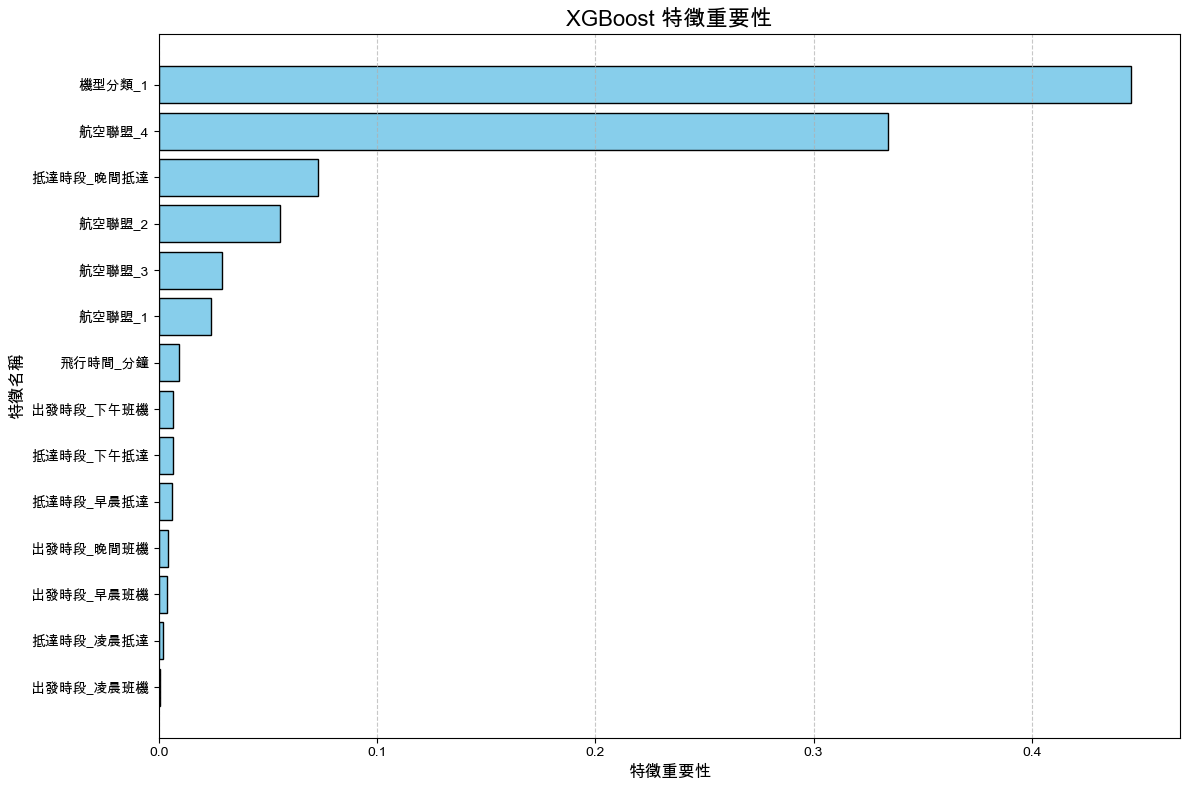

In [35]:
import matplotlib.pyplot as plt

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 確保特徵重要性已被計算
xgb_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(xgb_importance)[::-1]  # 排序

# 繪圖
plt.figure(figsize=(12, 8))
plt.barh(
    [X.columns[i] for i in sorted_idx],
    xgb_importance[sorted_idx],
    color="skyblue",
    edgecolor="black"
)
plt.gca().invert_yaxis()  # 反轉 y 軸，使重要特徵在最上面
plt.xlabel("特徵重要性", fontsize=12)
plt.ylabel("特徵名稱", fontsize=12)
plt.title("XGBoost 特徵重要性", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
